# <center>手写数字分类识别入门体验教程</center>

## 实现一个图片分类应用
## 概述
下面我们通过一个实际样例，带领大家体验MindSpore基础的功能，对于一般的用户而言，完成整个样例实践会持续20~30分钟。

本例子会实现一个简单的图片分类的功能，整体流程如下：

1. 处理需要的数据集，这里使用了MNIST数据集。

2. 定义一个网络，这里我们使用LeNet网络。

3. 定义损失函数和优化器。

4. 加载数据集并进行训练，训练完成后，查看结果及保存模型文件。

5. 加载保存的模型，进行推理。

6. 验证模型，加载测试数据集和训练后的模型，验证结果精度。

说明：<br/>你可以在这里找到完整可运行的样例代码：https://gitee.com/mindspore/docs/blob/master/tutorials/tutorial_code/lenet.py

## 训练的数据集下载

#### 方法一：
从以下网址下载，并将数据包解压缩后放至Jupyter的工作目录下：<br/>训练数据集：{"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"}
<br/>测试数据集：{"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"}<br/>我们用下面代码查询jupyter的工作目录。

In [1]:
import os
os.getcwd()

'C:\\Users\\Administrator'

训练数据集放在----`Jupyter工作目录+\MNIST_Data\train\`，此时train文件夹内应该包含两个文件，`train-images-idx3-ubyte`和`train-labels-idx1-ubyte` <br/>测试数据集放在----`Jupyter工作目录+\MNIST_Data\test\`，此时test文件夹内应该包含两个文件，`t10k-images-idx3-ubyte`和`t10k-labels-idx1-ubyte`

#### 方法二：
直接执行下面代码，会自动进行训练集的下载与解压，但是整个过程根据网络好坏情况会需要花费几分钟时间。

In [2]:
import urllib.request   
from urllib.parse import urlparse
import gzip 

def unzipfile(gzip_path):
    """unzip dataset file
    Args:
        gzip_path: dataset file path
    """
    open_file = open(gzip_path.replace('.gz',''), 'wb')
    gz_file = gzip.GzipFile(gzip_path)
    open_file.write(gz_file.read())
    gz_file.close()
    
def download_dataset():
    """Download the dataset from http://yann.lecun.com/exdb/mnist/."""
    print("******Downloading the MNIST dataset******")
    train_path = "./MNIST_Data/train/" 
    test_path = "./MNIST_Data/test/"
    train_path_check = os.path.exists(train_path)
    test_path_check = os.path.exists(test_path)
    if train_path_check == False and test_path_check == False:
        os.makedirs(train_path)
        os.makedirs(test_path)
    train_url = {"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"}
    test_url = {"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"}
    
    for url in train_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(train_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz', '')):
            file = urllib.request.urlretrieve(url, file_name)
            unzipfile(file_name)
            os.remove(file_name)
            
    for url in test_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(test_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz', '')):
            file = urllib.request.urlretrieve(url, file_name)
            unzipfile(file_name)
            os.remove(file_name)

download_dataset()

******Downloading the MNIST dataset******


这样就完成了数据集的下载解压缩工作。

## 处理MNIST数据集

由于我们后面会采用LeNet这样的卷积神经网络对数据集进行训练，而采用LeNet在训练数据时，对数据格式是有所要求的，所以接下来的工作需要我们先查看数据集内的数据是什么样的，这样才能构造一个针对性的数据转换函数，将数据集数据转换成符合训练要求的数据形式。

更多的LeNet网络的介绍不在此赘述，希望详细了解LeNet网络，可以查询http://yann.lecun.com/exdb/lenet/ 。

### 查看原始数据集数据

The type of mnist_ds: <class 'mindspore.dataset.engine.datasets.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 9


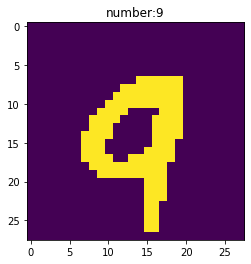

In [3]:
from mindspore import context
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

context.set_context(mode=context.GRAPH_MODE, device_target="CPU") 
train_data_path = "./MNIST_Data/train"
test_data_path = "./MNIST_Data/test"
mnist_ds = ds.MnistDataset(train_data_path)
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：",mnist_ds.get_dataset_size())

dic_ds = mnist_ds.create_dict_iterator()
item = dic_ds.get_next()
img = item["image"]
label = item["label"]

print("The item of mnist_ds:", item.keys())
print("Tensor of image in item:", img.shape) 
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s"% item["label"])
plt.show()

从上面的运行情况我们可以看到,训练数据集`train-images-idx3-ubyte`和`train-labels-idx1-ubyte`对应的是6万张图片和6万个数字下标，载入数据后经过`create_dict_iterator`转换字典型的数据集，取其中的一个数据查看，这是一个key为`image`和`label`的字典，其中的`image`的张量(高度28，宽度28，通道1)和`label`为对应图片的数字。

### 数据处理

数据集对于训练非常重要，好的数据集可以有效提高训练精度和效率，在加载数据集前，我们通常会对数据集进行一些处理。
#### 定义数据集及数据操作
我们定义一个函数`create_dataset`来创建数据集。在这个函数中，我们定义好需要进行的数据增强和处理操作：
1. 定义数据集。
2. 定义进行数据增强和处理所需要的一些参数。
3. 根据参数，生成对应的数据增强操作。
4. 使用`map`映射函数，将数据操作应用到数据集。
5. 对生成的数据集进行处理。

In [4]:
import mindspore.dataset.transforms.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.transforms.vision import Inter
from mindspore.common import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ create dataset for train or test
    Args:
        data_path (str): Data path
        batch_size (int): The number of data records in each group
        repeat_size (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # using map to apply operations to a dataset
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=num_parallel_workers)
    
    # process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds


其中
<br/>`batch_size`：每组包含的数据个数，现设置每组包含32个数据。
<br/>`repeat_size`：数据集复制的数量。
<br/>先进行`shuffle`、`batch`操作，再进行`repeat`操作，这样能保证1个`epoch`内数据不重复。

接下来我们查看将要进行训练的数据集内容是什么样的。

首先，查看数据集内包含多少组数据。

In [5]:
datas = create_dataset(train_data_path)
print('Number of groups in the dataset:', datas.get_dataset_size())

Number of groups in the dataset: 1875


其次，取出其中一组数据，查看包含的`key`，图片数据的张量，以及下标`labels`的值。

In [6]:
data = datas.create_dict_iterator().get_next()
print(data.keys())
images = data["image"] 
labels = data["label"] 
print('Tensor of image:', images.shape)
print('labels:', labels)

dict_keys(['label', 'image'])
Tensor of image: (32, 1, 32, 32)
labels: [6 3 5 8 9 0 1 8 1 6 8 9 1 3 0 9 0 4 0 2 2 6 7 9 4 9 1 4 1 4 3 3]


最后，查看`image`的图像和下标对应的值。

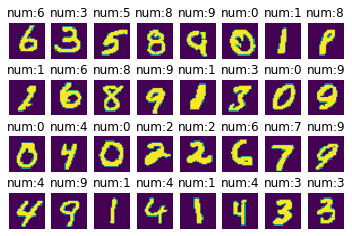

In [7]:
count = 1
for i in images:
    plt.subplot(4, 8, count) 
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

通过上述三个查询操作，看到经过变换后的图片，数据集内分成了1875组数据，每组数据中含有32张图片，每张图片像数值为32×32，数据全部准备好后，就可以进行下一步的数据训练了。

## 构造神经网络

在对手写字体识别上，通常采用卷积神经网络架构（CNN）进行学习预测，最经典的属1998年由Yann LeCun创建的LeNet5架构，<br/>其中分为：<br/>1、输入层；<br/>2、卷积层C1；<br/>3、池化层S2；<br/>4、卷积层C3；<br/>5、池化层S4；<br/>6、全连接F6；<br/>7、全连接；<br/>8、全连接OUTPUT。<br/>结构示意如下图:

### LeNet5结构图

<img src="https://www.mindspore.cn/tutorial/zh-CN/master/_images/LeNet_5.jpg" alt="LeNet5">

在构建LeNet5前，我们需要对全连接层以及卷积层进行初始化。

`TruncatedNormal`：参数初始化方法，MindSpore支持`TruncatedNormal`、`Normal`、`Uniform`等多种参数初始化方法，具体可以参考MindSpore API的`mindspore.common.initializer`模块说明。

初始化示例代码如下：

In [8]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal

# initialize 2D convolution function
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """Conv layer weight initial."""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")

# initialize full connection layer
def fc_with_initialize(input_channels, out_channels):
    """Fc layer weight initial."""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)

# set truncated normal distribution
def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)

使用MindSpore定义神经网络需要继承`mindspore.nn.cell.Cell`，`Cell`是所有神经网络（`Conv2d`等）的基类。

神经网络的各层需要预先在`__init__`方法中定义，然后通过定义`construct`方法来完成神经网络的前向构造，按照LeNet5的网络结构，定义网络各层如下：

In [9]:
class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self):
        super(LeNet5, self).__init__()
        self.batch_size = 32
        self.conv1 = conv(1, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x) 
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x) 
        return x

构建完成后，我们将LeNet5的整体参数打印出来查看一下。

In [10]:
network = LeNet5()
network

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5),stride=(1, 1),  pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False,weight_init=Parameter (name=conv1.weight), bias_init=None>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5),stride=(1, 1),  pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False,weight_init=Parameter (name=conv2.weight), bias_init=None>
  (fc1): Dense<in_channels=400, out_channels=120, weight=Parameter (name=fc1.weight), has_bias=True, bias=Parameter (name=fc1.bias)>
  (fc2): Dense<in_channels=120, out_channels=84, weight=Parameter (name=fc2.weight), has_bias=True, bias=Parameter (name=fc2.bias)>
  (fc3): Dense<in_channels=84, out_channels=10, weight=Parameter (name=fc3.weight), has_bias=True, bias=Parameter (name=fc3.bias)>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >

In [11]:
param = network.trainable_params()
param

[Parameter (name=conv1.weight),
 Parameter (name=conv2.weight),
 Parameter (name=fc1.weight),
 Parameter (name=fc1.bias),
 Parameter (name=fc2.weight),
 Parameter (name=fc2.bias),
 Parameter (name=fc3.weight),
 Parameter (name=fc3.bias)]

## 搭建训练网络并进行训练

构建完成神经网络后，就可以着手进行训练网络的构建，模型训练函数为`Model.train`，参数主要包含：
1. 圈数`epoch size`（每圈需要遍历完成1875组图片）；
2. 数据集`ds_train`；
3. 回调函数`callbacks`包含`ModelCheckpoint`、`LossMonitor`和`Callback`模型检测参数；
4. 数据下沉模式`dataset_sink_mode`，此参数默认`True`需设置成`False`，因为此功能不支持CPU模式。

In [12]:
# training related modules
from mindspore import Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor,Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy

def train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info):
    """Define the training method."""
    print("============== Starting Training ==============")
    # load training dataset
    ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(), step_loss_info], dataset_sink_mode=False)

自定义一个存储每一步训练的`step`和对应loss值的类`Step_loss_info`，并继承了`Callback`类，可以自定义训练过程中的处理措施，非常方便，等训练完成后，可将数据绘图查看loss的变化情况。

In [13]:
# custom callback function
class StepLossInfo(Callback):
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # step_loss dictionary for saving loss value and step number information
        step_loss["loss_value"].append(str(cb_params.net_outputs))
        step_loss["step"].append(str(cb_params.cur_step_num))

### 定义损失函数及优化器

在进行定义之前，先简单介绍损失函数及优化器的概念。

损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。深度学习通过不停地迭代来缩小损失函数的值。定义一个好的损失函数，可以有效提高模型的性能。

优化器：用于最小化损失函数，从而在训练过程中改进模型。

定义了损失函数后，可以得到损失函数关于权重的梯度。梯度用于指示优化器优化权重的方向，以提高模型性能。

定义损失函数。

MindSpore支持的损失函数有`SoftmaxCrossEntropyWithLogits`、`L1Loss`、`MSELoss`等。这里使用`SoftmaxCrossEntropyWithLogits`损失函数。

In [14]:
import os
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits

if os.name == "nt":
    # clean up old run files before in Windows
    os.system('del/f/s/q *.ckpt *.meta')
else:
    # clean up old run files before in Linux
    os.system('rm -f *.ckpt *.meta *.pb')

lr = 0.01
momentum = 0.9 

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')

# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )

epoch_size = 1
mnist_path = "./MNIST_Data"
# save the network model and parameters for subsequence fine-tuning
config_ck = CheckpointConfig(save_checkpoint_steps=125, keep_checkpoint_max=16)
# group layers into an object with training and evaluation features
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
# define step_loss dictionary for saving loss value and step number information
step_loss = {"step": [], "loss_value": []}
# save the steps and loss informations
step_loss_info = StepLossInfo()

repeat_size = 1
train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info)


============== Starting Training ==============
epoch: 1 step 1, loss is 2.3036417961120605
epoch: 1 step 2, loss is 2.298630714416504
epoch: 1 step 3, loss is 2.302391529083252
epoch: 1 step 4, loss is 2.304328441619873
epoch: 1 step 5, loss is 2.3027987480163574
epoch: 1 step 6, loss is 2.2987725734710693
epoch: 1 step 7, loss is 2.298673629760742
epoch: 1 step 8, loss is 2.30534029006958
epoch: 1 step 9, loss is 2.303036689758301
epoch: 1 step 10, loss is 2.2993321418762207
epoch: 1 step 11, loss is 2.305026054382324
epoch: 1 step 12, loss is 2.302748918533325
epoch: 1 step 13, loss is 2.3028924465179443
epoch: 1 step 14, loss is 2.2981364727020264
epoch: 1 step 15, loss is 2.3044252395629883
epoch: 1 step 16, loss is 2.2937963008880615
epoch: 1 step 17, loss is 2.302947759628296
epoch: 1 step 18, loss is 2.301767587661743
epoch: 1 step 19, loss is 2.302520275115967
epoch: 1 step 20, loss is 2.2997517585754395
epoch: 1 step 21, loss is 2.300358533859253
epoch: 1 step 22, loss is 2.2

epoch: 1 step 183, loss is 2.309624433517456
epoch: 1 step 184, loss is 2.323194742202759
epoch: 1 step 185, loss is 2.311706781387329
epoch: 1 step 186, loss is 2.3111326694488525
epoch: 1 step 187, loss is 2.3091180324554443
epoch: 1 step 188, loss is 2.2965402603149414
epoch: 1 step 189, loss is 2.295259475708008
epoch: 1 step 190, loss is 2.296231269836426
epoch: 1 step 191, loss is 2.303983211517334
epoch: 1 step 192, loss is 2.306814432144165
epoch: 1 step 193, loss is 2.2905185222625732
epoch: 1 step 194, loss is 2.308838367462158
epoch: 1 step 195, loss is 2.2948405742645264
epoch: 1 step 196, loss is 2.298696994781494
epoch: 1 step 197, loss is 2.2964284420013428
epoch: 1 step 198, loss is 2.3125040531158447
epoch: 1 step 199, loss is 2.2885444164276123
epoch: 1 step 200, loss is 2.306826114654541
epoch: 1 step 201, loss is 2.309328079223633
epoch: 1 step 202, loss is 2.2883524894714355
epoch: 1 step 203, loss is 2.304533004760742
epoch: 1 step 204, loss is 2.301948308944702
e

epoch: 1 step 363, loss is 2.316545009613037
epoch: 1 step 364, loss is 2.2973861694335938
epoch: 1 step 365, loss is 2.298579454421997
epoch: 1 step 366, loss is 2.299386978149414
epoch: 1 step 367, loss is 2.28235125541687
epoch: 1 step 368, loss is 2.312197208404541
epoch: 1 step 369, loss is 2.3015496730804443
epoch: 1 step 370, loss is 2.306972026824951
epoch: 1 step 371, loss is 2.300973892211914
epoch: 1 step 372, loss is 2.2951574325561523
epoch: 1 step 373, loss is 2.297781467437744
epoch: 1 step 374, loss is 2.2964324951171875
epoch: 1 step 375, loss is 2.3094630241394043
epoch: 1 step 376, loss is 2.3110594749450684
epoch: 1 step 377, loss is 2.316398859024048
epoch: 1 step 378, loss is 2.2969913482666016
epoch: 1 step 379, loss is 2.2993545532226562
epoch: 1 step 380, loss is 2.2793471813201904
epoch: 1 step 381, loss is 2.321284294128418
epoch: 1 step 382, loss is 2.308730363845825
epoch: 1 step 383, loss is 2.311279773712158
epoch: 1 step 384, loss is 2.2807345390319824
e

epoch: 1 step 544, loss is 2.2846484184265137
epoch: 1 step 545, loss is 2.303199052810669
epoch: 1 step 546, loss is 2.2937982082366943
epoch: 1 step 547, loss is 2.290144443511963
epoch: 1 step 548, loss is 2.292776346206665
epoch: 1 step 549, loss is 2.3142309188842773
epoch: 1 step 550, loss is 2.302577257156372
epoch: 1 step 551, loss is 2.2937214374542236
epoch: 1 step 552, loss is 2.298457145690918
epoch: 1 step 553, loss is 2.3043863773345947
epoch: 1 step 554, loss is 2.3041136264801025
epoch: 1 step 555, loss is 2.304441213607788
epoch: 1 step 556, loss is 2.2959136962890625
epoch: 1 step 557, loss is 2.287644624710083
epoch: 1 step 558, loss is 2.2996888160705566
epoch: 1 step 559, loss is 2.303114652633667
epoch: 1 step 560, loss is 2.3127856254577637
epoch: 1 step 561, loss is 2.2931501865386963
epoch: 1 step 562, loss is 2.3102290630340576
epoch: 1 step 563, loss is 2.3031444549560547
epoch: 1 step 564, loss is 2.3256449699401855
epoch: 1 step 565, loss is 2.3089632987976

epoch: 1 step 724, loss is 2.311528205871582
epoch: 1 step 725, loss is 2.2796037197113037
epoch: 1 step 726, loss is 2.2791337966918945
epoch: 1 step 727, loss is 2.2870848178863525
epoch: 1 step 728, loss is 2.2893407344818115
epoch: 1 step 729, loss is 2.3080923557281494
epoch: 1 step 730, loss is 2.281989574432373
epoch: 1 step 731, loss is 2.287876844406128
epoch: 1 step 732, loss is 2.2949070930480957
epoch: 1 step 733, loss is 2.3051536083221436
epoch: 1 step 734, loss is 2.2933919429779053
epoch: 1 step 735, loss is 2.2848522663116455
epoch: 1 step 736, loss is 2.296999216079712
epoch: 1 step 737, loss is 2.283834934234619
epoch: 1 step 738, loss is 2.313833475112915
epoch: 1 step 739, loss is 2.289297580718994
epoch: 1 step 740, loss is 2.3047103881835938
epoch: 1 step 741, loss is 2.310509443283081
epoch: 1 step 742, loss is 2.300405502319336
epoch: 1 step 743, loss is 2.2882189750671387
epoch: 1 step 744, loss is 2.2621119022369385
epoch: 1 step 745, loss is 2.29817986488342

epoch: 1 step 904, loss is 0.8959805369377136
epoch: 1 step 905, loss is 0.35969066619873047
epoch: 1 step 906, loss is 0.5569093823432922
epoch: 1 step 907, loss is 0.6490380167961121
epoch: 1 step 908, loss is 0.4854198098182678
epoch: 1 step 909, loss is 0.681684136390686
epoch: 1 step 910, loss is 0.5594454407691956
epoch: 1 step 911, loss is 0.28246811032295227
epoch: 1 step 912, loss is 0.564134955406189
epoch: 1 step 913, loss is 0.3480125367641449
epoch: 1 step 914, loss is 0.30245739221572876
epoch: 1 step 915, loss is 0.3057793080806732
epoch: 1 step 916, loss is 0.40296462178230286
epoch: 1 step 917, loss is 0.5620078444480896
epoch: 1 step 918, loss is 0.3885918855667114
epoch: 1 step 919, loss is 0.3405517637729645
epoch: 1 step 920, loss is 0.5268466472625732
epoch: 1 step 921, loss is 0.11871110647916794
epoch: 1 step 922, loss is 0.4030132293701172
epoch: 1 step 923, loss is 0.44585901498794556
epoch: 1 step 924, loss is 0.42256829142570496
epoch: 1 step 925, loss is 0.

epoch: 1 step 1078, loss is 0.22428953647613525
epoch: 1 step 1079, loss is 0.19300851225852966
epoch: 1 step 1080, loss is 0.13316313922405243
epoch: 1 step 1081, loss is 0.33551234006881714
epoch: 1 step 1082, loss is 0.6692869067192078
epoch: 1 step 1083, loss is 0.18172471225261688
epoch: 1 step 1084, loss is 0.44903361797332764
epoch: 1 step 1085, loss is 0.22222338616847992
epoch: 1 step 1086, loss is 0.23797328770160675
epoch: 1 step 1087, loss is 0.540205717086792
epoch: 1 step 1088, loss is 0.3685106635093689
epoch: 1 step 1089, loss is 0.34796908497810364
epoch: 1 step 1090, loss is 0.06477059423923492
epoch: 1 step 1091, loss is 0.2196572870016098
epoch: 1 step 1092, loss is 0.31783750653266907
epoch: 1 step 1093, loss is 0.4156820774078369
epoch: 1 step 1094, loss is 0.5367379784584045
epoch: 1 step 1095, loss is 0.2490120530128479
epoch: 1 step 1096, loss is 0.2063281387090683
epoch: 1 step 1097, loss is 0.3062203824520111
epoch: 1 step 1098, loss is 0.5498185753822327
epo

epoch: 1 step 1250, loss is 0.524069607257843
epoch: 1 step 1251, loss is 0.2652841806411743
epoch: 1 step 1252, loss is 0.2759210765361786
epoch: 1 step 1253, loss is 0.18665245175361633
epoch: 1 step 1254, loss is 0.30893442034721375
epoch: 1 step 1255, loss is 0.23022381961345673
epoch: 1 step 1256, loss is 0.12406717985868454
epoch: 1 step 1257, loss is 0.35657501220703125
epoch: 1 step 1258, loss is 0.1813289225101471
epoch: 1 step 1259, loss is 0.19929412007331848
epoch: 1 step 1260, loss is 0.3767518401145935
epoch: 1 step 1261, loss is 0.045815952122211456
epoch: 1 step 1262, loss is 0.3493342995643616
epoch: 1 step 1263, loss is 0.2095005214214325
epoch: 1 step 1264, loss is 0.038586486130952835
epoch: 1 step 1265, loss is 0.21155467629432678
epoch: 1 step 1266, loss is 0.1904488503932953
epoch: 1 step 1267, loss is 0.30973947048187256
epoch: 1 step 1268, loss is 0.0544302798807621
epoch: 1 step 1269, loss is 0.06591106206178665
epoch: 1 step 1270, loss is 0.48256736993789673


epoch: 1 step 1421, loss is 0.2732638716697693
epoch: 1 step 1422, loss is 0.28914135694503784
epoch: 1 step 1423, loss is 0.18879273533821106
epoch: 1 step 1424, loss is 0.13441845774650574
epoch: 1 step 1425, loss is 0.09011184424161911
epoch: 1 step 1426, loss is 0.1790235936641693
epoch: 1 step 1427, loss is 0.18365859985351562
epoch: 1 step 1428, loss is 0.030408916994929314
epoch: 1 step 1429, loss is 0.24467791616916656
epoch: 1 step 1430, loss is 0.29295310378074646
epoch: 1 step 1431, loss is 0.07330065965652466
epoch: 1 step 1432, loss is 0.11970701068639755
epoch: 1 step 1433, loss is 0.19104799628257751
epoch: 1 step 1434, loss is 0.22241932153701782
epoch: 1 step 1435, loss is 0.2240758091211319
epoch: 1 step 1436, loss is 0.10165629535913467
epoch: 1 step 1437, loss is 0.20622384548187256
epoch: 1 step 1438, loss is 0.22979219257831573
epoch: 1 step 1439, loss is 0.4825741946697235
epoch: 1 step 1440, loss is 0.34842449426651
epoch: 1 step 1441, loss is 0.2404418885707855

epoch: 1 step 1592, loss is 0.037289269268512726
epoch: 1 step 1593, loss is 0.6669546961784363
epoch: 1 step 1594, loss is 0.027973078191280365
epoch: 1 step 1595, loss is 0.3043333888053894
epoch: 1 step 1596, loss is 0.26716819405555725
epoch: 1 step 1597, loss is 0.3676808476448059
epoch: 1 step 1598, loss is 0.04774334654211998
epoch: 1 step 1599, loss is 0.1505802571773529
epoch: 1 step 1600, loss is 0.060209549963474274
epoch: 1 step 1601, loss is 0.1517183780670166
epoch: 1 step 1602, loss is 0.03348312899470329
epoch: 1 step 1603, loss is 0.2172851860523224
epoch: 1 step 1604, loss is 0.16908381879329681
epoch: 1 step 1605, loss is 0.4056672155857086
epoch: 1 step 1606, loss is 0.3545580506324768
epoch: 1 step 1607, loss is 0.0785195454955101
epoch: 1 step 1608, loss is 0.06628265231847763
epoch: 1 step 1609, loss is 0.17911334335803986
epoch: 1 step 1610, loss is 0.30736130475997925
epoch: 1 step 1611, loss is 0.22257380187511444
epoch: 1 step 1612, loss is 0.1460049748420715

epoch: 1 step 1764, loss is 0.18277199566364288
epoch: 1 step 1765, loss is 0.1360340714454651
epoch: 1 step 1766, loss is 0.017330918461084366
epoch: 1 step 1767, loss is 0.13024410605430603
epoch: 1 step 1768, loss is 0.29709434509277344
epoch: 1 step 1769, loss is 0.10498026013374329
epoch: 1 step 1770, loss is 0.11527147144079208
epoch: 1 step 1771, loss is 0.345134437084198
epoch: 1 step 1772, loss is 0.2717594802379608
epoch: 1 step 1773, loss is 0.2283378392457962
epoch: 1 step 1774, loss is 0.0384673997759819
epoch: 1 step 1775, loss is 0.176451176404953
epoch: 1 step 1776, loss is 0.09406087547540665
epoch: 1 step 1777, loss is 0.10655457526445389
epoch: 1 step 1778, loss is 0.11743699014186859
epoch: 1 step 1779, loss is 0.20475371181964874
epoch: 1 step 1780, loss is 0.11362048238515854
epoch: 1 step 1781, loss is 0.16925252974033356
epoch: 1 step 1782, loss is 0.1613941192626953
epoch: 1 step 1783, loss is 0.16446731984615326
epoch: 1 step 1784, loss is 0.2628989517688751
e

训练完成后，能在Jupyter的工作路径上生成多个模型文件，名称具体含义`checkpoint_{网络名称}-{第几个epoch}_{第几个step}.ckpt`。

#### 查看损失函数随着训练步数的变化情况

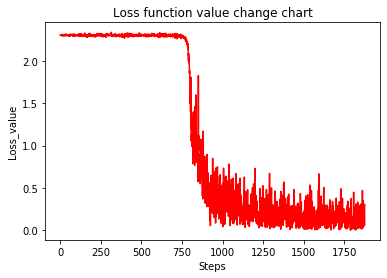

In [15]:
steps = step_loss["step"]
loss_value = step_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Loss function value change chart")
plt.show()

从上面可以看出来大致分为三个阶段：

阶段一：开始训练loss值在2.2上下浮动，训练收益感觉并不明显。

阶段二：训练到某一时刻，loss值减少迅速，训练收益大幅增加。

阶段三：loss值收敛到一定小的值后，loss值开始振荡在一个小的区间上无法趋0，再继续增加训练并无明显收益，至此训练结束。

##  数据测试验证模型精度

搭建测试网络的过程主要为：

1. 载入模型`.cptk`文件中的参数`param`；
2. 将参数`param`载入到神经网络LeNet5中；
3. 载入测试数据集；
4. 调用函数`model.eval`传入参数测试数据集`ds_eval`，就生成模型`checkpoint_lenet-1_1875.ckpt`的精度值。

> `dataset_sink_mode`表示数据集下沉模式，不支持CPU，所以这里设置成`False`。

In [16]:
# testing relate modules 
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9613381410256411} ==============


经过1875步训练后生成的模型精度超过95%，模型优良。
我们可以看一下模型随着训练步数变化，精度随之变化的情况。

`acc_model_info`函数是将每125步的保存的模型，调用`model.eval`函数将测试出的精度返回到步数列表和精度列表，如下：

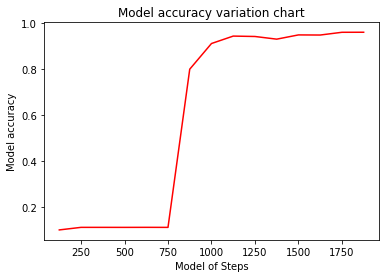

In [17]:
def acc_model_info(network, model, mnist_path, model_numbers):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, model_numbers+1):
        # load the saved model for evaluation
        param_dict = load_checkpoint("checkpoint_lenet-1_{}.ckpt".format(str(i*125)))
        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=False)
        acc_list.append(acc['Accuracy'])
        step_list.append(i*125)
    return step_list,acc_list

# draw line chart according to training steps and model accuracy
l1,l2 = acc_model_info(network, model, mnist_path, 15)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

从图中可以看出训练得到的模型精度变化分为三个阶段：1、缓慢上升，2、迅速上升，3、缓慢上升趋近于不到1的某个值时附近振荡，说明随着训练数据的增加，会对模型精度有着正相关的影响，但是随着精度到达一定程度，训练收益会降低。

## 模型预测应用

我们尝试使用生成的模型应用到分类预测单个或者单组图片数据上，具体步骤如下：

1. 需要将要测试的数据转换成适应LeNet5的数据类型。
2. 提取出`image`的数据。
3. 使用函数`model.predict`预测`image`对应的数字。需要说明的是`predict`返回的是`image`对应0-9的概率值。
4. 调用`plot_pie`将预测的各数字的概率显示出来。负概率的数字会被去掉。

载入要测试的数据集并调用`create_dataset`转换成符合格式要求的数据集，并选取其中一组32张图片进行预测。

Row 2, column 5 is incorrectly identified as 8, the correct value should be 3 

Row 3, column 3 is incorrectly identified as 5, the correct value should be 8 

Row 4, column 6 is incorrectly identified as 6, the correct value should be 0 

[8 0 5 4 9 1 8 7 0 5 2 4 8 2 4 1 2 1 5 3 9 8 5 7 1 9 3 8 2 6 0 1] <--Predicted figures
[8 0 5 4 9 1 8 7 0 5 2 4 3 2 4 1 2 1 8 3 9 8 5 7 1 9 3 8 2 0 0 1] <--The right number


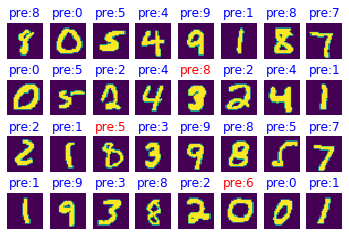

In [18]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = ds_test.get_next()
images = data["image"]
labels = data["label"]

output =model.predict(Tensor(data['image']))
prb = output.asnumpy()
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly！")
print(pred, "<--Predicted figures") 
print(labels, "<--The right number")
plt.show()

构建一个概率分析的饼图函数。

备注：`prb`为上一段代码中，存储这组数对应的数字概率。

Figure 1 probability of corresponding numbers [0-9]:
 [-3.4469228   2.0546532  -3.5465317  -1.3858355  -0.28758872  1.1322775
 -0.8353202  -3.6402948   8.3553      1.3656969 ]


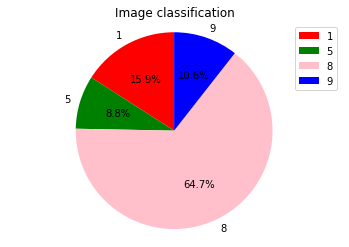

Figure 2 probability of corresponding numbers [0-9]:
 [10.008167   -5.861808    1.4555234  -1.482836   -2.721113   -0.8507886
  3.199972   -2.2156045   0.32849124 -1.4580953 ]


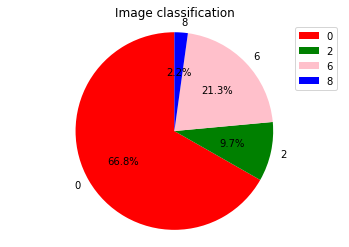

In [19]:
# define the pie drawing function of probability analysis
def plot_pie(prbs):
    dict1 = {}
    # remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()
    size = dict1.values()
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"] 
    color = colors[: len(size)]
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
    plt.axis("equal")
    plt.legend()
    plt.title("Image classification")
    plt.show()
    
    
for i in range(2):
    print("Figure {} probability of corresponding numbers [0-9]:\n".format(i+1), prb[i])
    plot_pie(prb[i])

以上过程就是这次手写数字分类训练的全部体验过程。